In [1]:
!pip install opencv-contrib-python tqdm matplotlib numpy ipywidgets


  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/81/3c/bbb3ceee9fbefc505f98c24dafda68c7b3c4f83b6951c0712b4623fe4cce/opencv_contrib_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-win_amd64.whl (44.8 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\eaell\\Anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import cv2
from cv2 import aruco

import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, clear_output
import time
import math

# Find the USB camera connected to the PC
def find_camera_index(i):
    cap = cv2.Videocapture(i)
    if cap.isOpened():
        print(f"Camera index {i} found.")
        cap.release()
        return(i)
    else:
        print(f"No camera found at index {i}.")
        return find_camera_index(i+1)

#
def show_frame(frame):
    _, img_encoded = cv2.imencode('.png', frame)
    IPython.display.display(IPython.display.Image(data=img_encoded.tobytes()))

#
def vector_to_angle(vector):
    angle = -math.atan2(vector[1], vector[0])
    return angle

# Define the upper and lower RGB color limit of a given image 
def upper_lower_color(color_sample, c):
    # Define the upper and lower limit of the color given the sample image 
    mean, stddev = cv2.meanStdDev(color_sample)
    lower_color = mean - c*stddev
    upper_color = mean + c*stddev
    return lower_color, upper_color

# Given a frame, give the contour of all pixels in the image of a particular color.
def find_contours(frame, color, c):
    lower_b, upper_b = upper_lower_color(color, c)
    # Find contours in the binary mask
    mask = cv2.inRange(frame, lower_b, upper_b)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_center(corners):
    # Get the pixel coordinates of the corners of the marker
    marker_corners = np.int32(corners)
    # Calculate the centroid of the marker
    centroid = np.round(np.mean(marker_corners, axis=0, dtype=np.int32)).astype(int)
    return centroid

# Class Obj defining all the objects to be recognized with the camera.
class Obj:
    def __init__(self, id, img_pos = np.array([[]])):
        self.id = id
        self.img_pos = img_pos
        self.corners = ()

    """ def detect(self,frame,detector):
        corners, _, _ = detector.detectMarkers(frame, ids = cv2.UMat(np.array([self.id])))
        if np.size(corners,0) > 0:
            centers = []
            for i in range(np.size(corners,0)):
                print('Corners :', corners[i].get())
                centers.append(get_center(corners[i].get()))
                print('Center i :', get_center(corners[i].get()))
            print('Centers :', corners)
            self.img_pos = np.array(centers)
        self.corners = corners
        return"""
    
    def get_img_dir(self):
        img_dir = []
        for p in range(np.size(self.corners,0)):
            if np.size(self.corners[p]) > 0:
                c1 = self.corners[p][0]
                c2 = self.corners[p][1]
                c3 = self.corners[p][2]
                c4 = self.corners[p][3]
                front = np.mean([c1,c2], 0)
                back = np.mean([c3,c4], 0)
                img_dir.append(front-back)
        return np.array(img_dir)
    
    def draw(self, frame, color):
        for p in range(np.size(self.img_pos,0)):
            if np.size(self.img_pos[p]) > 0:
                cv2.circle(frame, self.img_pos[p], 5, color, -1)
        return
        

# Class Map define a map given three references objects and their respective distances. 
# This map can be used to localize other objects given a frame of the actual view.
class Map:
    def __init__(self, ref1, ref2, ref3, distance_r1r2 = 650, distance_r3r2 = 600):
        self.ref1 = ref1
        self.ref1_pos = np.array([1, 0])
        self.ref2 = ref2
        self.ref2_pos = np.array([0, 0])
        self.ref3 = ref3
        self.ref3_pos = np.array([0, 1])
        self.origin = np.array([0, 0])
        self.distance_r1r2 = distance_r1r2  #[mm]
        self.distance_r3r2 = distance_r3r2  #[mm]
        self.e1 = (self.ref1_pos - self.ref2_pos)/np.linalg.norm(self.ref1_pos - self.ref2_pos)
        self.e2 = (self.ref3_pos - self.ref2_pos)/np.linalg.norm(self.ref3_pos - self.ref2_pos)
        self.scale = np.array([distance_r1r2/np.linalg.norm(self.ref1_pos - self.ref2_pos), distance_r3r2/np.linalg.norm(self.ref3_pos - self.ref2_pos)])
        
    def loc_img2map(self, frame, img_coordinates):
        if np.size(img_coordinates) > 1:
            r1_img_pos = self.ref1.img_pos[0]
            r2_img_pos = self.ref2.img_pos[0]
            r3_img_pos = self.ref3.img_pos[0]
            e1_img = r1_img_pos - r2_img_pos
            e2_img = r3_img_pos - r2_img_pos
            basis = np.array([e1_img,e2_img])
            # Check if the basis vectors form a linearly independent set
            if np.linalg.matrix_rank(basis) != 2:
                return np.array([])
            else:
                map_coordinates = np.linalg.solve(np.transpose(basis), img_coordinates-r2_img_pos)
                map_coordinates = np.multiply(map_coordinates, self.scale)
                return map_coordinates
        else:
            return np.array([])
    
    def vec_img2map(self, frame, img_coordinates):
        if np.size(img_coordinates) > 1:
            r1_img_pos = self.ref1.img_pos[0]
            r2_img_pos = self.ref2.img_pos[0]
            r3_img_pos = self.ref3.img_pos[0]
            e1_img = r1_img_pos - r2_img_pos
            e2_img = r3_img_pos - r2_img_pos
            basis = np.array([e1_img,e2_img])
            # Check if the basis vectors form a linearly independent set
            if np.linalg.matrix_rank(basis) != 2:
                return np.array([])
            else:
                map_coordinates = np.linalg.solve(np.transpose(basis), img_coordinates)
                map_coordinates = np.multiply(map_coordinates, self.scale)
                return map_coordinates
        else:
            return np.array([])
    
    def loc_map2img(self, frame, map_coordinates):
        if np.size(map_coordinates) > 1:
            map_coordinates = np.divide(map_coordinates, self.scale)
            r1_img_pos = self.ref1.img_pos[0]
            r2_img_pos = self.ref2.img_pos[0]
            r3_img_pos = self.ref3.img_pos[0]
            e1_img = r1_img_pos - r2_img_pos
            e2_img = r3_img_pos - r2_img_pos
            img_coordinates = np.round(r2_img_pos + map_coordinates[0]*e1_img + map_coordinates[1]*e2_img).astype(int)
            return img_coordinates
        else:
            return np.array([])
    
    def localize(self, frame, obj):
        img_coordinates = obj.img_pos
        map_pos = []
        for o in range(np.size(img_coordinates,0)):
            map_pos.append(self.loc_img2map(frame, img_coordinates[o]))
        return np.array(map_pos)
    
    def matrix(self, frame, objects, robot, goal):
        # Print the map in a matrix format with the given objects represented as numbers
        square_size = 50 #[mm]
        margins = 0
        origin = np.array([margins, margins])
        matrix = np.zeros([2*margins+self.distance_r1r2//square_size,2*margins+self.distance_r1r2//square_size])
        # Write the obstacles positions in the matrix with a 1
        for o in range(len(objects)):
            map_pos = self.localize(frame,objects[o])
            for p in range(np.size(map_pos,0)):
                if np.size(map_pos[p]) > 0:
                    if not(np.isnan(map_pos[p]).any()):
                        mat_pos = origin + np.round(np.divide(map_pos[p],square_size)).astype(int)
                        if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                            matrix[mat_pos[0],mat_pos[1]] = 1
                        if np.size(objects[o].boundingRect[p]) > 0:
                            x,y,w,h = objects[o].boundingRect[p]
                            left_top_corner = self.loc_img2map(frame,np.array([x,y]))
                            right_bottom_corner = self.loc_img2map(frame,np.array([x+w,y+h]))
                            mat_l_t_c = origin + np.round(np.multiply(left_top_corner, np.divide(self.scale,square_size))).astype(int)
                            mat_r_b_c = origin + np.round(np.multiply(right_bottom_corner, np.divide(self.scale,square_size))).astype(int)
                            if mat_l_t_c[0] > 0 and mat_l_t_c[1] > 0 and mat_l_t_c[0] < np.size(matrix,0) and mat_l_t_c[1] < np.size(matrix,1):
                                if mat_r_b_c[0] > np.size(matrix,0):
                                    mat_r_b_c[0] = np.size(matrix,0)-1
                                if mat_r_b_c[1] > np.size(matrix,1):
                                    mat_r_b_c[1] = np.size(matrix,1)-1
                                if mat_r_b_c[0] < 0:
                                    mat_r_b_c[0] = 0
                                if mat_r_b_c[1] < 0:
                                    mat_r_b_c[1] = 0
                                if mat_l_t_c[0] > mat_r_b_c[0]:
                                    tmp = mat_l_t_c[0]
                                    mat_l_t_c[0] = mat_r_b_c[0]
                                    mat_r_b_c[0] = tmp
                                if mat_l_t_c[1] > mat_r_b_c[1]:
                                    tmp = mat_l_t_c[1]
                                    mat_l_t_c[1] = mat_r_b_c[1]
                                    mat_r_b_c[1] = tmp
                                matrix[mat_l_t_c[0]:mat_r_b_c[0], mat_l_t_c[1]:mat_r_b_c[1]] = np.ones([abs(mat_r_b_c[0]-mat_l_t_c[0]),abs(mat_r_b_c[1]-mat_l_t_c[1])])
                            else:
                                if mat_r_b_c[0] > 0 and mat_r_b_c[1] > 0 and mat_r_b_c[0] < np.size(matrix,0) and mat_r_b_c[1] < np.size(matrix,1):
                                    if mat_l_t_c[0] < 0:
                                        mat_l_t_c[0] = 0
                                    if mat_l_t_c[1] < 0:
                                        mat_l_t_c[1] = 0
                                    if mat_l_t_c[0] > np.size(matrix,0):
                                        mat_l_t_c[0] = np.size(matrix,0)-1
                                    if mat_l_t_c[1] > np.size(matrix,1):
                                        mat_l_t_c[1] = np.size(matrix,1)-1
                                    if mat_l_t_c[0] > mat_r_b_c[0]:
                                        tmp = mat_l_t_c[0]
                                        mat_l_t_c[0] = mat_r_b_c[0]
                                        mat_r_b_c[0] = tmp
                                    if mat_l_t_c[1] > mat_r_b_c[1]:
                                        tmp = mat_l_t_c[1]
                                        mat_l_t_c[1] = mat_r_b_c[1]
                                        mat_r_b_c[1] = tmp
                                    matrix[mat_l_t_c[0]:mat_r_b_c[0], mat_l_t_c[1]:mat_r_b_c[1]] = np.ones([abs(mat_r_b_c[0]-mat_l_t_c[0]), abs(mat_r_b_c[1]-mat_l_t_c[1])])
        # Write the robot position in the matrix with a 2
        map_pos = self.localize(frame,robot)
        if np.size(map_pos,0) > 0:
            if not(np.isnan(map_pos[0]).any()):
                mat_pos = origin + np.round(np.divide(map_pos[0],square_size)).astype(int)
                if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                    matrix[mat_pos[0],mat_pos[1]] = 2
        # Write the goal position in the matrix with a 3
        map_pos = self.localize(frame,goal)
        if np.size(map_pos,0) > 0:
            if not(np.isnan(map_pos[0]).any()):
                mat_pos = origin + np.round(np.divide(map_pos[0],square_size)).astype(int)
                if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                    matrix[mat_pos[0],mat_pos[1]] = 3
            else:
                print('Empty pos')    
        else:
            print('No goal')                    
        """# Write the ref positions in the matrix with a 4
        for o in range(len(refs)):
            map_pos = self.localize(frame,refs[o])
            for p in range(np.size(map_pos,0)):
                if np.size(map_pos[p]) > 0:
                    if not(np.isnan(map_pos[p]).any()):
                        mat_pos = origin + np.round(np.divide(map_pos,square_size)).astype(int)
                        if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                            matrix[mat_pos[0],mat_pos[1]] = 4 """
        return matrix


    



In [2]:
# Create an adjusted dictionary of 5 markers of 4x4 bits.
aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
# Assign a marker to each objects to be recognized on the map
# Generate three reference markers
ref_ids = np.array([0, 1, 2])
arr = np.zeros([7,7])
ref_markers = []

for i in range(5):
    marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
    ref_markers.append(marker)
    cv2.imwrite('marker' + str(i) +'.jpg', marker)
print('Test')
# Definition of the references used to map the space
ref1 = Obj(0, np.array([[0,0]]))
ref2 = Obj(1, np.array([[0,0]]))
ref3 = Obj(2, np.array([[0,0]]))

#map = Map(ref1, ref2, ref3)

# Definition of the objects to recognize in the space
goal = Obj(3, np.array([[]]))
thymio = Obj(4, np.array([[]]))

map = Map(ref1,ref2,ref3,700,700)

objects = np.array([ref1,ref2, ref3, goal, thymio])


Test


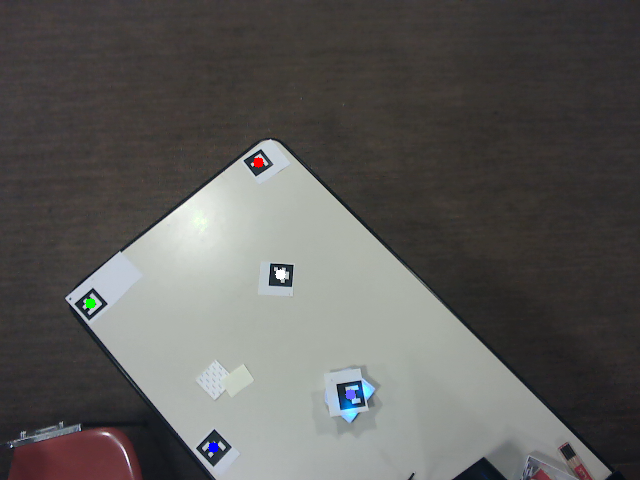

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Thymio map pos [[875.49295775 442.34741784]]
Thymio map dir -2.97975522235137


KeyboardInterrupt: 

In [4]:
                
# Capture video from your camera or load an image
cap = cv2.VideoCapture(0)  # Change to the camera index or video file path if using video
corners = np.array([[]])

#for i in range(3):
while True:
    ret, frame = cap.read()
    if not ret:
        break
    clear_output(wait=True)
    #show_frame(frame)
    new_frame = frame.copy()
    rejectedCandidates = np.array([[]])
    parameters = cv2.aruco.DetectorParameters()
    parameters.adaptiveThreshWinSizeMin = 10
    parameters.adaptiveThreshWinSizeMax = 100
    parameters.adaptiveThreshWinSizeStep = 10
    """ parameters.minMarkerPerimeterRate = 0.03
    parameters.maxMarkerPerimeterRate = 4.0
    parameters.polygonalApproxAccuracyRate = 0.05
    parameters.minCornerDistanceRate = 0.05
    parameters.minDistanceToBorder = 3
    parameters.minMarkerDistanceRate = 0.05
    parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
    parameters.cornerRefinementWinSize = 5
    parameters.cornerRefinementMaxIterations = 30
    parameters.cornerRefinementMinAccuracy = 0.1
    parameters.markerBorderBits = 1
    parameters.perspectiveRemovePixelPerCell = 4
    parameters.perspectiveRemoveIgnoredMarginPerCell = 0.13
    parameters.maxErroneousBitsInBorderRate = 0.04
    parameters.minOtsuStdDev = 60.0
    parameters.errorCorrectionRate = 0.6 """
    detector = cv2.aruco.ArucoDetector(aruco_dictionary, parameters)
    corners, ids, _ = detector.detectMarkers(frame)
    for o in range(np.size(objects,0)):
        centers = []
        c = []
        if np.size(corners,0) > 0:
            for i in range(np.size(ids,0)):
                if objects[o].id == ids[i][0]:
                    centers.append(get_center(corners[i][0]))
                    c.append(corners[i][0])
        objects[o].img_pos = np.array(centers)
        objects[o].corners = np.array(c)

    
    
    ref1.draw(new_frame, [255,0,0])
    ref2.draw(new_frame, [0,255,0])
    ref3.draw(new_frame, [0,0,255])
    goal.draw(new_frame, [255,255,255])
    thymio.draw(new_frame, [255,100,100])
    show_frame(new_frame)
    if (np.size(ref1.img_pos,0) > 0) and (np.size(ref2.img_pos,0) > 0) and (np.size(ref3.img_pos,0) > 0):
        print(map.matrix(frame,[],thymio,goal))
        print('Thymio map pos', map.localize(frame, thymio))
        if(np.size(thymio.get_img_dir(), 0)> 0):
            print('Thymio map dir', vector_to_angle(thymio.get_img_dir()[0]))
    time.sleep(0.5)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()

In [23]:
# Define the size of the Charuco board (number of squares along the width and height)
board_width = 6
board_height = 4
square_size = 0.025  # Size of each square in meters

# Generate Charuco board
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = cv2.aruco.CharucoBoard([board_width, board_height], 0.025, 0.0125, dictionary)
board_image = board.generateImage((100 * board_width, 100 * board_height))
show_frame(board_image)
cv2.imwrite('board.jpg',board_image)
# Create a list to store Charuco board images and corresponding object points
all_charuco_corners = []
all_charuco_ids = []
all_object_points = []


# Capture video from the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    clear_output(wait=True)

    # Detect Charuco board corners and ids
    detector_params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, detector_params)
    corners, ids, _ = detector.detectMarkers(frame)
    chardetect = cv2.aruco.CharucoDetector(board,cv2.aruco.CharucoParameters(),detector_params)
    charuco_corners, charuco_ids, _, _ = chardetect.detectBoard(frame)

    # If Charuco board is detected, display it
    if charuco_corners is not None and charuco_ids is not None:
        #cv2.aruco.drawDetectedMarkers(frame, corners, ids)
        cv2.aruco.drawDetectedCornersCharuco(frame, charuco_corners, charuco_ids)

        # Store Charuco board corners, ids, and object points
        all_charuco_corners = charuco_corners
        all_charuco_ids = charuco_ids
        all_object_points = board.getChessboardCorners()
        print(all_object_points)
        print(all_charuco_corners)
        # Create a list to store object points (3D points in real-world coordinates)

        if len(all_charuco_corners) > 0:
            ret, camera_matrix, dist_coeffs, _, _ = cv2.calibrateCamera(all_object_points, all_charuco_corners, frame.shape[1:], None, None)

    show_frame(frame)

# Release the camera
cap.release()
cv2.destroyAllWindows()

# Perform camera calibration


IndentationError: expected an indented block after 'if' statement on line 47 (2228285499.py, line 50)

In [ ]:
# Create an adjusted dictionary of 5 markers of 4x4 bits.
aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
# Assign a marker to each objects to be recognized on the map
# Generate three reference markers
ref_ids = np.array([0, 1, 2])
arr = np.zeros([7,7])
ref_markers = []

for i in range(5):
    marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
    ref_markers.append(marker)
    cv2.imwrite('marker' + str(i) +'.jpg', marker)
print('Test')
# Definition of the references used to map the space
ref1 = Obj(0, np.array([[0,0]]))
ref2 = Obj(1, np.array([[0,0]]))
ref3 = Obj(2, np.array([[0,0]]))

#map = Map(ref1, ref2, ref3)

# Definition of the objects to recognize in the space
goal = Obj(3, np.array([[]]))
thymio = Obj(4, np.array([[]]))

map = Map(ref1,ref2,ref3,700,700)

objects = np.array([ref1,ref2, ref3, goal, thymio])
                
# Capture video from your camera or load an image
cap = cv2.VideoCapture(0)  # Change to the camera index or video file path if using video
corners = np.array([[]])

#for i in range(3):
while True:
    ret, frame = cap.read()
    if not ret:
        break
    clear_output(wait=True)
    #show_frame(frame)
    new_frame = frame.copy()
    rejectedCandidates = np.array([[]])
    parameters = cv2.aruco.DetectorParameters()
    parameters.adaptiveThreshWinSizeMin = 10
    parameters.adaptiveThreshWinSizeMax = 100
    parameters.adaptiveThreshWinSizeStep = 10
    """ parameters.minMarkerPerimeterRate = 0.03
    parameters.maxMarkerPerimeterRate = 4.0
    parameters.polygonalApproxAccuracyRate = 0.05
    parameters.minCornerDistanceRate = 0.05
    parameters.minDistanceToBorder = 3
    parameters.minMarkerDistanceRate = 0.05
    parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
    parameters.cornerRefinementWinSize = 5
    parameters.cornerRefinementMaxIterations = 30
    parameters.cornerRefinementMinAccuracy = 0.1
    parameters.markerBorderBits = 1
    parameters.perspectiveRemovePixelPerCell = 4
    parameters.perspectiveRemoveIgnoredMarginPerCell = 0.13
    parameters.maxErroneousBitsInBorderRate = 0.04
    parameters.minOtsuStdDev = 60.0
    parameters.errorCorrectionRate = 0.6 """
    detector = cv2.aruco.ArucoDetector(aruco_dictionary, parameters)
    corners, ids, _ = detector.detectMarkers(frame)
    for o in range(np.size(objects,0)):
        centers = []
        c = []
        if np.size(corners,0) > 0:
            for i in range(np.size(ids,0)):
                if objects[o].id == ids[i][0]:
                    centers.append(get_center(corners[i][0]))
                    c.append(corners[i][0])
        objects[o].img_pos = np.array(centers)
        objects[o].corners = np.array(c)

    
    
    ref1.draw(new_frame, [255,0,0])
    ref2.draw(new_frame, [0,255,0])
    ref3.draw(new_frame, [0,0,255])
    goal.draw(new_frame, [255,255,255])
    thymio.draw(new_frame, [255,100,100])
    show_frame(new_frame)
    if (np.size(ref1.img_pos,0) > 0) and (np.size(ref2.img_pos,0) > 0) and (np.size(ref3.img_pos,0) > 0):
        print(map.matrix(frame,[],thymio,goal))
        print('Thymio map pos', map.localize(frame, thymio))
        if(np.size(thymio.get_img_dir(), 0)> 0):
            print('Thymio map dir', vector_to_angle(thymio.get_img_dir()[0]))
    time.sleep(0.5)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()